In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import math
from tqdm import tqdm

from PIL import Image
import os
import copy
from imagecorruptions import corrupt

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import StandardScaler


In [3]:
from sklearn.decomposition import PCA

In [4]:
os.chdir("..")
from safeml.DistanceMetricsParallel import Anderson_Darling_Dist_PVal as AD_p
from safeml.DistanceMetricsParallel import Kolmogorov_Smirnov_Dist_PVal as KS_p
#os.chdir("..")

In [5]:
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 32
width = 32
channels = 3

n_inputs = height * width*channels

ClassFolders = os.listdir("Final_Training/Images")
classes = len(ClassFolders)

for idx, fileName in enumerate(ClassFolders) :
    path = os.path.join("Final_Training/Images", fileName)
    #path = "C:/cmder/Python_Tests/GTSRB/Train/{0}/".format(i)
    print(path)
    classImges = os.listdir(path)
    for img in classImges:
        try:
            image=cv2.imread(os.path.join(path, img))
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(idx)
        except AttributeError:
            print(os.path.join(path, img) + " is not an image")
            
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

Final_Training/Images\00001
Final_Training/Images\00001\GT-00001.csv is not an image
Final_Training/Images\00002
Final_Training/Images\00002\GT-00002.csv is not an image
Final_Training/Images\00003
Final_Training/Images\00003\GT-00003.csv is not an image
Final_Training/Images\00004
Final_Training/Images\00004\GT-00004.csv is not an image
Final_Training/Images\00005
Final_Training/Images\00005\GT-00005.csv is not an image
Final_Training/Images\00006
Final_Training/Images\00006\GT-00006.csv is not an image
Final_Training/Images\00007
Final_Training/Images\00007\GT-00007.csv is not an image
Final_Training/Images\00008
Final_Training/Images\00008\GT-00008.csv is not an image
Final_Training/Images\00009
Final_Training/Images\00009\GT-00009.csv is not an image
Final_Training/Images\00010
Final_Training/Images\00010\GT-00010.csv is not an image
Final_Training/Images\00011
Final_Training/Images\00011\GT-00011.csv is not an image
Final_Training/Images\00012
Final_Training/Images\00012\GT-00012.

In [6]:
X_train_init, X_val_init, y_train_init, y_val_init = train_test_split(Cells, labels, test_size=0.40, random_state=42, stratify=labels)
X_val_init, X_test_init, y_val_init, y_test_init = train_test_split(X_val_init, y_val_init, test_size=0.7, random_state=42, stratify=y_val_init)


In [7]:
X_train = X_train_init.astype('float32')/255 
X_val = X_val_init.astype('float32')/255
X_test = X_test_init.astype('float32')/255 #all will be normalized, but corrupted images will be overwritten

In [8]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train_init.shape, y_val_init.shape, y_test_init.shape)

(22555, 32, 32, 3) (4511, 32, 32, 3) (10526, 32, 32, 3)
(22555,) (4511,) (10526,)


In [11]:
#select a random 50% fo the test data indecies to be corrupted
corruption_id = np.random.choice(X_test.shape[0], size = math.ceil(0.5 *X_test.shape[0]), replace=False)

# in percentages, 0-75 frost, 25-100 fog with 25-50 overlap
first_corruption = corruption_id[:math.ceil(0.75*len(corruption_id))]
second_corruption = corruption_id[math.ceil(0.25*len(corruption_id)):]

corr_type = ['frost', 'fog']
X_test_corrupted = copy.deepcopy(X_test) #copy to override

for batch in tqdm(corr_type):
    idx_list = first_corruption if batch == 0 else second_corruption
    for i in idx_list:
    
            
        image = X_test_init[i,:]
        image = (corrupt(np.array(image), corruption_name=batch, severity=5)).astype('float32')/255

        X_test_corrupted[i,:] = image.astype('float32')/255 #normalize
            

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.17s/it]


In [12]:
y_train = keras.utils.to_categorical(y_train_init, classes)
y_val = keras.utils.to_categorical(y_val_init, classes)
y_test = keras.utils.to_categorical(y_test_init, classes)

In [13]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(22555, 32, 32, 3) (4511, 32, 32, 3) (10526, 32, 32, 3)
(22555, 42) (4511, 42) (10526, 42)


In [14]:
def build_model(input_shape, num_features, num_labels):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(num_features, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))

    return model

def compile_model(model, lr, loss='categorical_crossentropy', optimizer='adam', acc_metric = "accuracy"):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
    model.compile(loss=loss, optimizer=optimizer, metrics=[acc_metric])
    
    return model

In [15]:
lr = .001
max_epochs = 50
patience = 3
batch_size = 128
input_shape = X_train.shape[1:]
num_features = 100
num_labels = classes

In [16]:
model = build_model(input_shape, num_features, num_labels)
model = compile_model(model, lr)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                    

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)                    
history = model.fit(X_train, y_train, epochs=max_epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                            shuffle=False, callbacks=[callback])

Epoch 1/50
202/202 [==============================] - 20s 96ms/step - loss: 2.0265 - accuracy: 0.4326 - val_loss: 0.5694 - val_accuracy: 0.8193
Epoch 2/50
202/202 [==============================] - 19s 95ms/step - loss: 0.5277 - accuracy: 0.8291 - val_loss: 0.1791 - val_accuracy: 0.9645
Epoch 3/50
202/202 [==============================] - 19s 96ms/step - loss: 0.2726 - accuracy: 0.9153 - val_loss: 0.0943 - val_accuracy: 0.9775
Epoch 4/50
202/202 [==============================] - 19s 96ms/step - loss: 0.1816 - accuracy: 0.9425 - val_loss: 0.0668 - val_accuracy: 0.9824
Epoch 5/50
202/202 [==============================] - 19s 97ms/step - loss: 0.1390 - accuracy: 0.9570 - val_loss: 0.0450 - val_accuracy: 0.9888
Epoch 6/50
202/202 [==============================] - 19s 96ms/step - loss: 0.1064 - accuracy: 0.9679 - val_loss: 0.0407 - val_accuracy: 0.9891
Epoch 7/50
202/202 [==============================] - 19s 96ms/step - loss: 0.0917 - accuracy: 0.9716 - val_loss: 0.0392 - val_accuracy:

In [18]:
accr = model.evaluate(X_test_corrupted, y_test)
print(accr)

329/329 [==============================] - 3s 9ms/step - loss: 1.4049 - accuracy: 0.6440
[1.40494704246521, 0.6440243124961853]


In [19]:
y_pred = np.argmax(model.predict(X_test_corrupted), 1)
y_real = np.argmax(y_test, 1)

329/329 [==============================] - 3s 8ms/step


# Distance

In [51]:
def get_statistical_distance(train_set, test_set):
    #return statistical distance measures
    if (train_set.shape[1] != test_set.shape[1]):
        print(f"input features are not compatible. input one size {train_set.shape[1]} does not match input two size {test_set.shape[1]}")
        return None
    else:
        df_features = train_set.shape[1]
        
    df_features = train_set.shape[1]

    Anderson_Darling_distances = np.zeros(df_features)
    Kolmogorov_Smirnov_distances = np.zeros(df_features)

    ss_Anderson_Darling_distances = np.zeros(df_features)
    ss_Kolmogorov_Smirnov_distances = np.zeros(df_features)

    for i in range(df_features):
        
        pVal_ad, ad_res = AD_p(train_set[:, i], test_set[:, i])
        ss_Anderson_Darling_distances[i] = ad_res if (pVal_ad < 0.05) else np.nan
        
        pVal_ks, ks_res = KS_p(train_set[:, i], test_set[:, i])
        ss_Kolmogorov_Smirnov_distances[i] = ks_res if (pVal_ks < 0.05) else np.nan
        
    
    Anderson_Darling_distance = (np.nanmean(ss_Anderson_Darling_distances, dtype=np.float64),
                                 np.nanstd(ss_Anderson_Darling_distances, dtype=np.float64))
    Kolmogorov_Smirnov_distance = (np.nanmean(ss_Kolmogorov_Smirnov_distances, dtype=np.float64),
                                   np.nanstd(ss_Kolmogorov_Smirnov_distances, dtype=np.float64))
 
    return {
            'Anderson_Darling_dist': Anderson_Darling_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance
           }

In [22]:
def KS_crit(alpha, n, m):
    """calculates scaled the critical distance value at which hypothesis test is rejected for two samples testing
    with arrays of different sizes Kolmogrov Sirminov test.
    
    Args:
        alpha (float): confidance level of the hypothesis test
        n (int): size of array 1
        m (int): size of array 2
        
    Returns:
        (flaot): critical value c(a)"""
    
    c = math.sqrt((-1 * math.log(alpha/2)) * 0.5)
    scale = math.sqrt((n+m)/(n*m))

    return c*scale

In [23]:
vals = pd.read_csv("C:/Users/harit/Documents/Fraunhofer/AD_crit.csv", index_col=0)

def AD_crit(alpha, n, m, trails = None):
    """calculates scaled the critical distance value at which hypothesis test is rejected for two samples testing
    with arrays of different sizes for Anderson Darling test.
    
    Args:
        alpha (float): confidance level of the hypothesis test
        n (int): size of array 1
        m (int): size of array 2
        
    Returns:
        (flaot): critical value c(a)"""
    k = n + m
    ad_infDict = {.15:1.610, .1: 1.9335, .05:2.4921, .01:3.857}
    #print(ad_infDict[alpha])
    if (trails is not None):
        #vals = pd.read_csv("C:/Users/harit/Documents/Fraunhofer/AD_crit.csv", index_col=0)
        ad_inf = vals[str(alpha)].loc[trails]
    else:
        if (alpha not in ad_infDict.keys()):
            ad_inf = interpolate_AD_inf(alpha)
        else:
            ad_inf = ad_infDict[alpha]
        

    c = (ad_inf - 1)*(1 - (1.55/k)) + 1
    
    return c

In [24]:
mask = np.zeros(len(y_pred))
for idx, yp in enumerate(y_pred):
    mask[idx] = yp == y_real[idx]
    
print(mask)

[0. 1. 1. ... 0. 0. 1.]


In [25]:
print(len(mask) - mask.sum() )

3747.0


In [26]:
def create_filter(model):
    
    x = model.layers[-2].output
    output = Model(inputs = model.input, outputs= x)
    
    return output

In [27]:
filter_model = create_filter(model)

In [32]:
filtered_train = filter_model.predict(X_train)
filtered_test = filter_model.predict(X_test_corrupted)

329/329 [==============================] - 3s 8ms/step


In [33]:
pca = PCA(n_components=15)
train_components = pca.fit_transform(filtered_train)
print(pca.explained_variance_)

[313.69485  191.80424  154.9346   138.44246  106.84725   99.90351
  86.58457   81.33255   73.04969   48.20887   41.880775  33.02903
  29.081758  24.65776   20.98061 ]


In [34]:
explained = pca.explained_variance_ratio_
explained = [sum(explained[:x]) for x in range(1,len(explained))]
print(explained)

[0.19487132132053375, 0.31402261555194855, 0.41027000546455383, 0.4962722659111023, 0.562647171318531, 0.6247085332870483, 0.6784959957003593, 0.7290208339691162, 0.7744002528488636, 0.8043482303619385, 0.8303651139140129, 0.8508831765502691, 0.8689491432160139, 0.884266865439713]


In [35]:
test_components = pca.transform(filtered_test)

In [37]:
test_correct = test_components[mask == 1, :12]
test_incorrect = test_components[mask ==0, :12]

print(test_correct.shape, test_incorrect.shape)

(6779, 12) (3747, 12)


In [38]:
train_samplespace = train_components[:, :12]
print(train_samplespace.shape)

(22555, 12)


In [41]:
val_range = range(5, 101, 5)

correct_dist = np.zeros((2, len(val_range)))
incorrect_dist = np.zeros((2, len(val_range)))

for idx, smp_n in tqdm(enumerate(val_range)):
    idx_train = np.random.choice(train_samplespace.shape[0], smp_n, replace=False)
    idx_correct = np.random.choice(test_correct.shape[0], smp_n, replace=False)
    idx_incorrect = np.random.choice(test_incorrect.shape[0], smp_n, replace=False)

    correct = get_statistical_distance(train_samplespace[idx_train], test_correct[idx_correct])
    incorrect = get_statistical_distance(train_samplespace[idx_train], test_incorrect[idx_incorrect])
    
    for dist_idx, dist_name in enumerate(['Anderson_Darling_dist', 'Kolmogorov_Smirnov_dist']):
        correct_dist[dist_idx, idx] = correct[dist_name][0]
        incorrect_dist[dist_idx, idx] = incorrect[dist_name][0]


20it [00:45,  2.28s/it]


In [42]:
crit_vals = np.zeros((2, len(val_range)))

for idx, smp_n in tqdm(enumerate(val_range)):
    #cvm_crit_vals[0, idx] = CVM_crit(0.1, smp_n)
    crit_vals[0, idx] = AD_crit(0.1, smp_n, smp_n)
    crit_vals[1, idx] = KS_crit(0.1, smp_n, smp_n)
    

20it [00:00, ?it/s]


In [43]:
len(range(5, 101, 5))

20

In [44]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

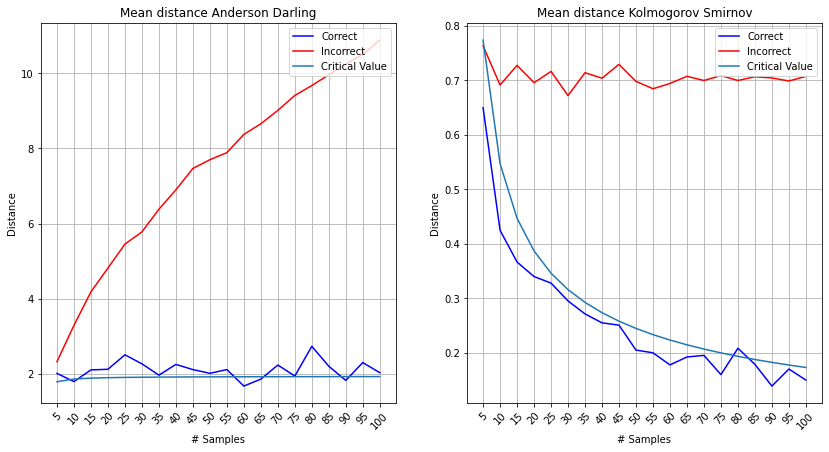

In [49]:
column_names=[
                "Anderson Darling",
                "Kolmogorov Smirnov",

            ]

fig=plt.figure(figsize=[14,7])
columns = 2
rows = 1
#for factor in range(15):
    #correct_meas, incorrect_meas = to_numpy(lst_correct_list[factor], lst_correct_list[factor])
for i in range(1, 3):
    plt.subplot(rows, columns, i)
    y1, y2 = correct_dist[i-1,:], incorrect_dist[i-1,:]
    #print(y1, y2)
    nans, x= nan_helper(y1)
    if (nans.sum()):
        y1[nans]= np.interp(x(nans), x(~nans), y1[~nans])

    plt.plot(y1, 'b')
    plt.plot(y2, 'r')
    plt.plot(crit_vals[i-1,:], )
    plt.xticks(range(20), range(5, 101, 5), rotation = 45)
    title_str = "Mean distance " + column_names[i-1]
    plt.title(title_str)
    plt.legend(["Correct", "Incorrect", "Critical Value"], loc = 1)
    plt.ylabel("Distance")
    plt.xlabel("# Samples")
    plt.grid()
plt.show()

# Bootstrap

In [52]:
value_range = range(5, 101, 5)
trails = 100
alpha = 0.1

crit_vals = np.zeros((2, len(value_range)))
false_positive = np.zeros((2, len(value_range)))
false_negative = np.zeros((2, len(value_range)))


for idx, smp_n in (enumerate(value_range)):
    crit_vals[0, idx] = AD_crit(0.1, smp_n, smp_n, trails)
    crit_vals[1, idx] = KS_crit(0.1/trails, smp_n, smp_n)
    
    for sim_number in range(trails):
        #print("sim: ", sim_number)
        
        idx_train = np.random.choice(train_samplespace.shape[0], smp_n, replace=False)
        idx_correct = np.random.choice(test_correct.shape[0], smp_n, replace=False)
        idx_incorrect = np.random.choice(test_incorrect.shape[0], smp_n, replace=False)

        dist_correct = get_statistical_distance(train_samplespace[idx_train], test_correct[idx_correct])
        dist_incorrect = get_statistical_distance(train_samplespace[idx_train], test_incorrect[idx_incorrect])
    
        for test, col in enumerate(["Anderson_Darling_dist", "Kolmogorov_Smirnov_dist"]):
            
            false_positive[test, idx] += 1 if dist_correct[col][0] > crit_vals[test, idx] else 0
            false_negative[test, idx] += 1 if dist_incorrect[col][0] < crit_vals[test, idx] else 0
    print("sample idx: ", idx)

            

<ipython-input-51-40d706fa38b8>:26: RuntimeWarning: Mean of empty slice
  Anderson_Darling_distance = (np.nanmean(ss_Anderson_Darling_distances, dtype=np.float64),
c:\users\harit\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-51-40d706fa38b8>:28: RuntimeWarning: Mean of empty slice
  Kolmogorov_Smirnov_distance = (np.nanmean(ss_Kolmogorov_Smirnov_distances, dtype=np.float64),


sample idx:  0
sample idx:  1
sample idx:  2
sample idx:  3
sample idx:  4
sample idx:  5
sample idx:  6
sample idx:  7
sample idx:  8
sample idx:  9
sample idx:  10
sample idx:  11
sample idx:  12
sample idx:  13
sample idx:  14
sample idx:  15
sample idx:  16
sample idx:  17
sample idx:  18
sample idx:  19


In [53]:
power = (2*trails - false_positive - false_negative)/(2*trails)
fnr = false_negative/100

In [64]:
power

array([[0.5  , 0.5  , 0.5  , 0.5  , 0.5  , 0.88 , 0.95 , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   ],
       [0.5  , 0.5  , 0.725, 0.8  , 0.85 , 0.875, 0.95 , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   ]])

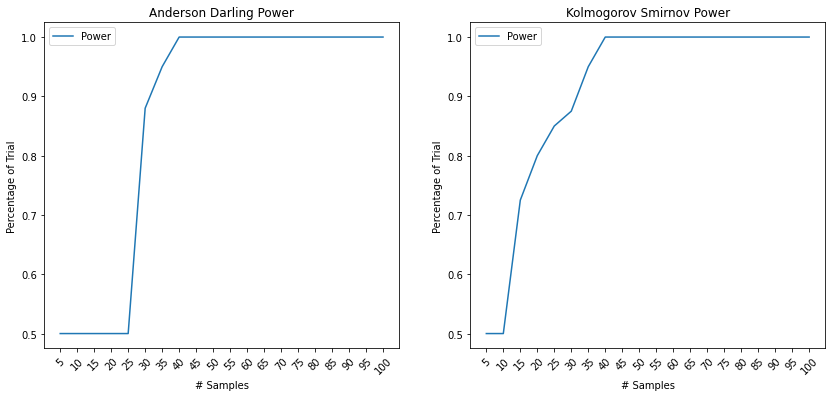

In [69]:
fig=plt.figure(figsize=[14,6])
columns = 2
rows = 1

for i in range(2):
    plt.subplot(rows, columns, i+1)
    y1, y2 = power[i,:], fnr[i,:]
    #print(y1, y2)
    nans, x= nan_helper(y1)
    if (nans.sum()):
        y1[nans]= np.interp(x(nans), x(~nans), y1[~nans])

    plt.plot(y1)
    #plt.plot(y2, 'r')
    plt.xticks(range(20), range(5, 101, 5), rotation = 45)
    title_str = column_names[i] + " Power"
    plt.title(title_str)
    plt.legend(["Power", "False negative rate"], loc = 2)
    plt.ylabel("Percentage of Trial")
    plt.xlabel("# Samples")
    
plt.show()